In [1]:
import matplotlib.pyplot as pyplot, networkx as nx, numpy as np
import fiona, json, matplotlib, osmnx, shapely, statistics
from random import random, choice
%matplotlib inline

In [2]:
# Create networkx graph of roads within the Tampines region in Singapore
graph = osmnx.graph_from_place('Tampines, Singapore', which_result=2, network_type='drive', simplify=False)

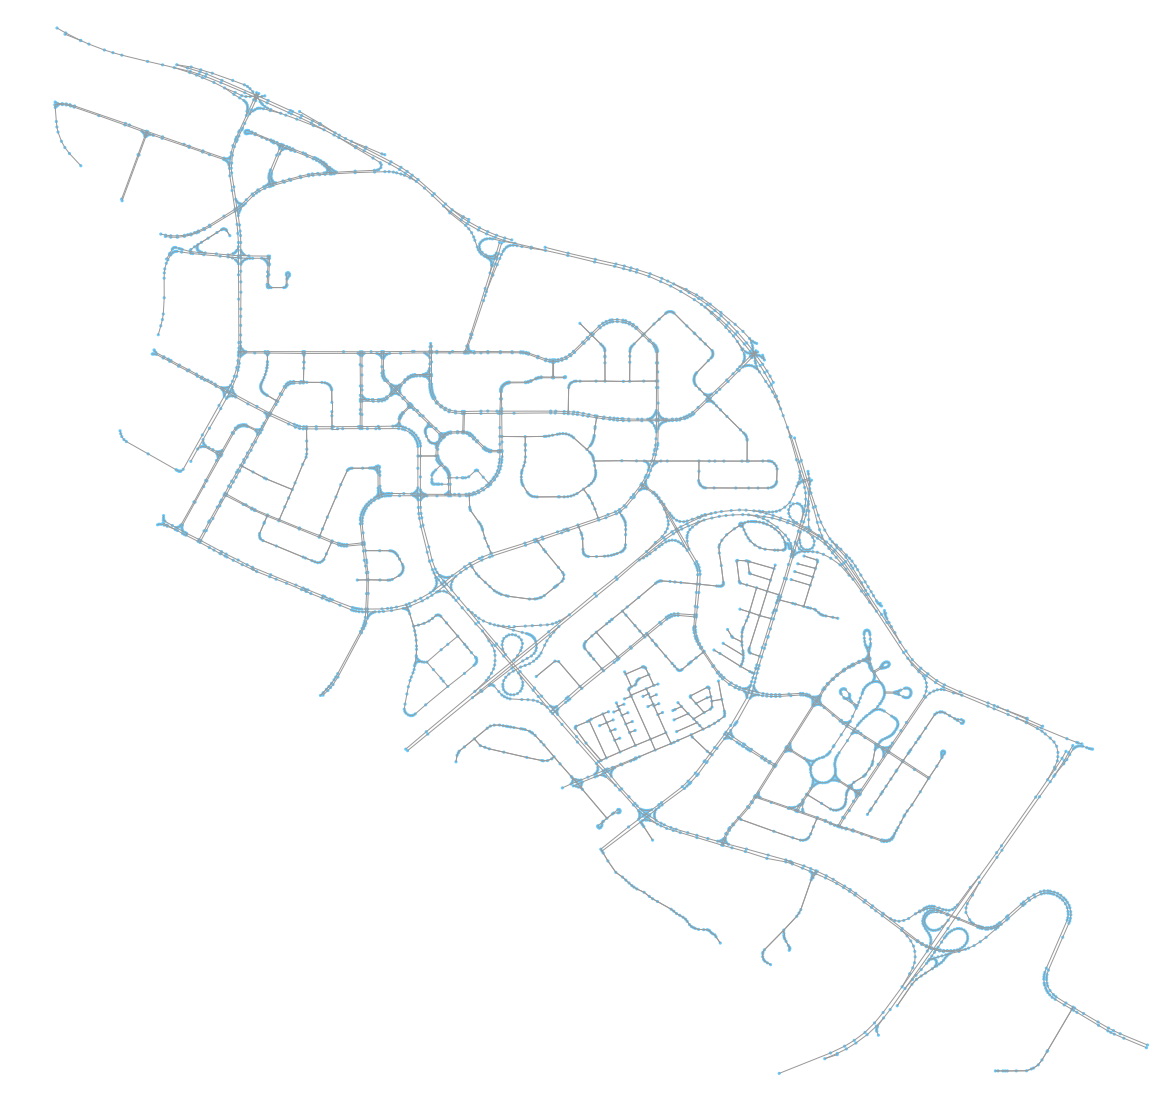

In [6]:
# Generate figure of networkx graph 
fig, ax = osmnx.plot_graph(graph, fig_height=20, node_size=10)

In [7]:
# Determine how long it takes to travel from one node to another
default_speed_limit = 50

def kph_to_mps(speed):
    return speed * 1000 / 3600

def update_travel_duration(edge_data):
    if 'maxspeed' in edge_data:
        speed = float(edge_data['maxspeed'])
    else:
        speed = default_speed_limit
        
    edge_data['duration'] = float(edge_data['length']) / kph_to_mps(speed)


def accumulate_travel_duration(edge_data):
    if type(edge_data['duration']) is list:
        edge_data['duration'] = sum(edge_data['duration'])

for node, neighbour, key in graph.edges:
    edge_data = graph.get_edge_data(node, neighbour, key)
    update_travel_duration(edge_data)

graph = osmnx.simplify_graph(graph)

for node, neighbour, key in graph.edges:
    edge_data = graph.get_edge_data(node, neighbour, key)
    accumulate_travel_duration(edge_data)

In [8]:
# Remove dead ends in graph
graph.remove_edge(1781950263, 1781950250)
graph.remove_edge(1781950250, 1781950263)

graph = osmnx.remove_isolated_nodes(graph)

out_degree_0 = []

for node_id in graph.__iter__():
    if graph.out_degree(node_id) == 0 and graph.in_degree(node_id) > 0:
        out_degree_0.append(node_id)

while out_degree_0:
    for node_id in graph.__iter__():
        if graph.out_degree(node_id) == 0 and graph.in_degree(node_id) > 0:
            predecessors = list(graph.predecessors(node_id))
            for pred_id in predecessors:
                graph.remove_edge(pred_id, node_id)
    
    out_degree_0 = []
    for node_id in graph.__iter__():
        if graph.out_degree(node_id) == 0 and graph.in_degree(node_id) > 0:
            out_degree_0.append(node_id)

graph = osmnx.remove_isolated_nodes(graph)

In [9]:
# Get taxi GPS pickup data
drop_off_states = list(graph.__iter__())
with open('/home/akj/Desktop/osmosis/pick_up.json') as pick_up_GPS_file:
    pick_up_json = json.load(pick_up_GPS_file)
    pick_up_GPSes = pick_up_json["features"][0]["geometry"]["coordinates"]
    
    pick_up_graph = nx.MultiDiGraph()
    pick_up_graph.graph['crs'] = {'init' :'epsg:4326'}

    p_id = 0
    for GPS in pick_up_GPSes:
        pick_up_graph.add_node(p_id, x= GPS[0], y= GPS[1])
        p_id += 1

    # Filter out pick up points outside of Tampines
    tampines_polygon = osmnx.gdf_from_place('Tampines, Singapore', which_result=2)
    osmnx.save_gdf_shapefile(tampines_polygon, filename="Tampines")

    with fiona.open("data/Tampines/Tampines.shp") as f_collection:
        raw_shape = next(iter(f_collection))
        tampines_shape = shapely.geometry.asShape(raw_shape['geometry'])

        pick_up_graph = osmnx.core.truncate_graph_polygon(pick_up_graph, tampines_shape, retain_all=True)
    
    pick_up_states = []
    for pick_up_id in pick_up_graph.__iter__():
        pick_up_point = pick_up_graph.node[pick_up_id]
        pick_up_state = osmnx.utils.get_nearest_node(graph, (pick_up_point['y'], pick_up_point['x']))
        pick_up_states.append(pick_up_state)


In [10]:
# Q and reward functions for Q-learning
Q = {}
R = {}
reward = 10000

for state in graph.__iter__():
    for action in graph.successors(state):
        Q[state, action] = 0
        R[state, action] = -graph.get_edge_data(state, action, 0)['duration']

for pick_up_state in pick_up_states:
    for pred_id in graph.predecessors(pick_up_state):
        R[pred_id, pick_up_state] = reward

In [11]:
# Setup for Q-learning
duration_lst = []
avg_duration_lst = []
pathing = {}
episode_count = 0

visit_count = {x:0 for x in graph.__iter__()}
found_count = {x:0 for x in graph.__iter__()}
existence_probability = {x:0 for x in graph.__iter__()}

alpha = 0.25
gamma = 0.25
epsilon = 0.1

durations = []
for state in graph.__iter__():
    for action in graph.successors(state):
        durations.append(graph.get_edge_data(state, action, 0)['duration'])
eta = statistics.stdev(durations)

def max_Q(graph, Q, state):
    greatest = -float("inf")
    for action in graph.successors(state):
        if Q[state, action] > greatest:
            greatest = Q[state, action]
    return greatest


def greatest_Q(graph, Q, state, original_action):
    greatest = -float("inf")
    for action in graph.successors(state):
        if action != original_action and Q[state, action] > greatest:
            greatest = Q[state, action]
    return greatest

In [12]:
# Perform Q-learning using LB/Proba for 10000 episodes,
# keeping track of average durations of 1000 episodes
while episode_count < 10000:
    start = choice(drop_off_states)
    state = start
    has_picked_up_customer = False
    
    pathing[start] = []
    duration = 0

    while not has_picked_up_customer:
        action = None
        
        # If greedy
        if random() >= epsilon:
            successors = []
            for action in graph.successors(state):
                if Q[state, action] >= greatest_Q(graph, Q, state, action) - eta:
                    successors.append(action)
            if len(successors) > 1:
                highest_prob = 0
                highest_id = 0
                for action in successors:
                    if existence_probability[action] > highest_prob:
                        highest_prob = existence_probability[action]
                        highest_id = action
                if highest_prob == 0: # Not enough data to determine probability
                    action = choice(successors)
                else: # Select action with highest probability of meeting passenger
                    action = highest_id
            else: # Only one to choose from
                action = successors[0]
        else: # Not greedy
            action = choice(list(graph.successors(state)))

        Q[state, action] = Q[state, action] \
                        + alpha * (R[state, action] + gamma * max_Q(graph, Q, action) - Q[state, action])

        visit_count[action] += 1
        existence_probability[action] = found_count[action] / visit_count[action]
        duration += graph.get_edge_data(state, action, 0)['duration']
        pathing[start].append(action)

        if action in pick_up_states:
            duration_lst.append(duration)
            found_count[action] += 1
            episode_count += 1
            has_picked_up_customer = True

            if episode_count % 1000 == 0:
                avg_duration_lst.append(sum(duration_lst)/1000)
                duration_lst = []
        else:
            state = action

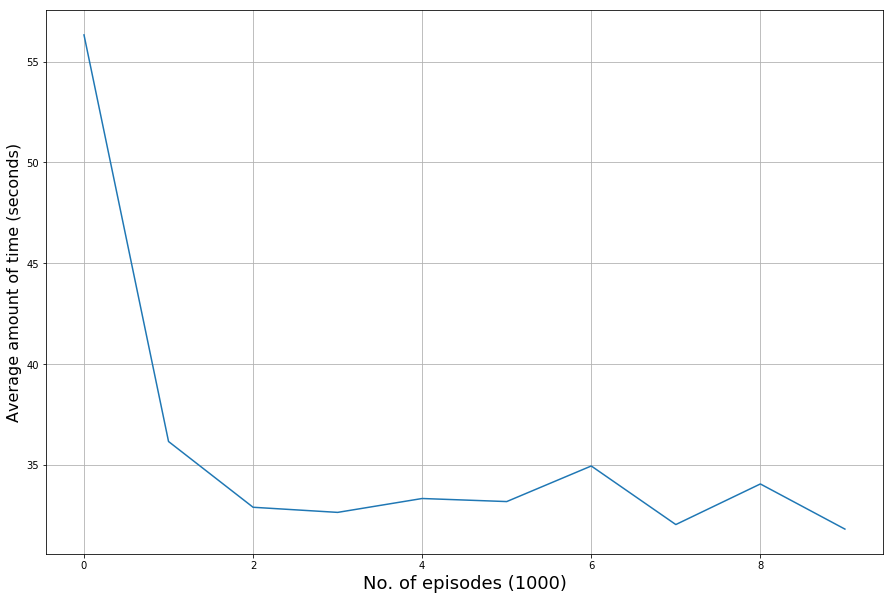

In [13]:
fig_size = pyplot.rcParams['figure.figsize']
fig_size[0] = 15
fig_size[1] = 10
pyplot.plot(avg_duration_lst)
pyplot.xlabel('No. of episodes (1000)', fontsize=18)
pyplot.ylabel('Average amount of time (seconds)', fontsize=16)
pyplot.grid()
fig.savefig('test.jpg')